# Preparing the Environment

In [1]:
import datetime as dt
import itertools
import os
import pickle
from dataclasses import dataclass
from pathlib import Path

import colorcet as cc
import geopandas as gpd
import git
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import osmnx as ox
import pandas as pd
import pyodbc
import requests
import seaborn as sns; sns.set_theme(style='white')
import shapely
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from sktime.forecasting.model_selection import temporal_train_test_split
from sqlalchemy import create_engine
from tqdm.notebook import tqdm

## Setting paths and loading `app` dependencies

In [3]:
REPO_ROOT = Path(git.Repo('.', search_parent_directories=True).working_tree_dir).absolute()
DATA_RAW_PATH = REPO_ROOT / 'data' / 'raw'
OCCUPANCY_FEATHER_PATH = DATA_RAW_PATH / 'parking_zone_occupancy_aggr.feather'
MODELS_CACHE = REPO_ROOT / '.cache'

OCCUPANCY_FEATHER_PATH.parent.mkdir(exist_ok=True)
MODELS_CACHE.mkdir(exist_ok=True)

%cd -q $REPO_ROOT

import app.keeper_of_the_state
from app.constants import DAY_OF_WEEK
from app.constants import UNENFORCED_DAYS
from app.data_formats import APIPredictionRequest

In [4]:
def load_occupancy_dataset(remove_inactive_timeslots=True):
    if OCCUPANCY_FEATHER_PATH.exists():
        occupancy = pd.read_feather(OCCUPANCY_FEATHER_PATH)
    else:
        occupancy = pd.read_sql_query(
            r'''
                SELECT *
                FROM [dbo].[parking_zone_occupancy_aggr]
                ORDER BY zone_name, semihour
            ''',
            'mssql+pyodbc://{user}:{password}@{server_url}:{server_port}/{database}?driver={driver}'.format(
                user='padmin',
                password=os.getenv('SQL_SERVER_PASSWORD'),
                server_url='dev-data-science-parking-prediction.crrvm15jali6.us-west-2.rds.amazonaws.com',
                server_port='1433',
                database='parking_prediction',
                driver='ODBC+Driver+17+for+SQL+Server'
            )
        )
        occupancy.to_feather(OCCUPANCY_FEATHER_PATH)

    return (occupancy.rename(columns={'zone_name': 'zone_id'})
                     .pipe(remove_unoccupied_timeslots if remove_inactive_timeslots else lambda df: df)
                     .pipe(remove_times_outside_hours_of_operation)
                     .pipe(derive_features))


def remove_unoccupied_timeslots(occupancy_dataframe: pd.DataFrame) -> pd.DataFrame:
    return occupancy_dataframe.loc[(
        (occupancy_dataframe.no_data != 1)
      & (occupancy_dataframe.no_trxn_one_week_flg != 1)
    )]


def remove_times_outside_hours_of_operation(occupancy_dataframe: pd.DataFrame) -> pd.DataFrame:
    enforcement_days = [day.value for day in DAY_OF_WEEK
                        if day not in UNENFORCED_DAYS]
    return (
        occupancy_dataframe
            .set_index('semihour')
            .between_time('08:00', '22:00', include_end=False)
            .reset_index()
            .loc[lambda df: df.semihour.dt.dayofweek.isin(enforcement_days), :]
    )


def derive_features(occupancy_dataframe: pd.DataFrame) -> pd.DataFrame:
    return occupancy_dataframe.assign(
        available_rate=lambda df: 1 - df.occu_cnt_rate,
        dayofweek=lambda df: df.semihour.dt.dayofweek.astype('category'),
        semihour_tuples=lambda df: pd.Series(
            zip(df.semihour.dt.hour, df.semihour.dt.minute),
            dtype='category', index=df.index
        )
    )


occupancy = load_occupancy_dataset()

TRAINING_WEEKS = 53


def training_end_offset(number_of_weeks=TRAINING_WEEKS, with_hours=True):
    offset_arguments = {'days': 7 * number_of_weeks - 1}
    if with_hours:
        offset_arguments['hours'] = 22
    return pd.DateOffset(**offset_arguments)


def training_bounds(start_date, number_of_weeks=TRAINING_WEEKS):
    start_date = pd.Timestamp(start_date).normalize()
    start_timestamp = start_date + pd.DateOffset(hours=8)
    end_timestamp = start_date + training_end_offset(number_of_weeks) - pd.Timedelta('1 nanosecond')
    return start_timestamp, end_timestamp


def testing_bounds(training_start_date, training_weeks=TRAINING_WEEKS):
    training_end_date = training_bounds(training_start_date, number_of_weeks=training_weeks)[1]
    testing_end_date = training_end_date + pd.Timedelta(days=1)
    testing_start_date = testing_end_date.normalize() + pd.DateOffset(hours=8)
    return testing_start_date, testing_end_date


example_first_day = '2018-09-17'
example_first_day_ts = pd.Timestamp(example_first_day)

example_train_start, example_train_end = training_bounds(example_first_day)
example_test_start, example_test_end = testing_bounds(example_first_day)

assert example_first_day_ts.normalize() == example_train_start.normalize()
assert (example_train_end - example_train_start).days == 7 * TRAINING_WEEKS - 1
assert example_train_start.day_name() == (example_train_end + pd.DateOffset(days=1)).day_name()
assert example_test_start.normalize() == example_train_end.normalize() + pd.DateOffset(days=1)
assert example_test_start.normalize() == example_test_end.normalize()


TRAINING_START_DATES = [f'2018-09-{day:0>2}' for day in range(17, 23)]

EARLIEST_TRAINING_DATETIME = training_bounds(TRAINING_START_DATES[0])[0]
LATEST_TESTING_DATETIME = testing_bounds(TRAINING_START_DATES[-1])[1]


def zones_spanning_period(df, start_date, end_date, zone_column='zone_id', timestamp_column='semihour',
                          eps=pd.Timedelta(minutes=30)):
    '''
    Returns all zones in `df` with records from `start_date` to `end_date`
    (inclusive).
    
    Zones are admitted if they are associated with records within `eps` of both
    bounds (exclusive).
    '''
    zone_is_admissible = (
        (df.groupby(zone_column)[timestamp_column].min() - start_date < eps) &
        (end_date - df.groupby(zone_column)[timestamp_column].max() < eps)
    )
    return zone_is_admissible[zone_is_admissible].index


def training_and_testing_data(
        df, training_start_date,
        timestamp_column='semihour', zone_column='zone_id',
        number_of_weeks=TRAINING_WEEKS
    ):
    training_start, training_end = training_bounds(training_start_date, number_of_weeks=number_of_weeks)
    testing_start, testing_end = testing_bounds(training_start_date, training_weeks=number_of_weeks)

    train_data = df[df[timestamp_column].between(training_start, training_end)]
    test_data = df[df[timestamp_column].between(testing_start, testing_end)]

    zones_under_test = zones_spanning_period(
        df, training_start, testing_end,
        timestamp_column=timestamp_column, zone_column=zone_column
    )

    return (
        train_data[train_data[zone_column].isin(zones_under_test)],
        test_data[test_data[zone_column].isin(zones_under_test)]
    )


example_train, example_test = training_and_testing_data(occupancy, example_first_day)

assert example_train.semihour.min() == example_train_start
assert (
    example_train_end - example_train.semihour.max() <= pd.Timedelta(minutes=30)
    or (
        example_train_end - example_train.semihour.max() <= pd.Timedelta(days=1, minutes=30)
        and example_train_start.day_name() == 'Monday'
    )
)

assert example_test.semihour.min() == example_test_start
assert example_test_end - example_test.semihour.max() < pd.Timedelta(minutes=30)

/Users/daniel.r.moore/Library/Caches/pypoetry/virtualenvs/predictive-parking-J8Xdfjko-py3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3417: UserWarning: Discarding nonzero nanoseconds in conversion
  exec(code_obj, self.user_global_ns, self.user_ns)


# Moving Averages

- Semihour
  - Last 7 Days
  - Last 1 DOW
  - Last 4 DOWs
  - Last 12 DOWs
  - Last 24 DOWs

In [ ]:
sns.lineplot(
    data=occupancy,
    x='semihour',
    y='available_rate',
)

In [57]:
windows_in_weeks = [1, 2, 3, 4, 12, 24]

In [96]:
occupancy = occupancy.sort_values(['zone_id', 'dayofweek', 'semihour_tuples'])

for weeks in tqdm(windows_in_weeks):
    occupancy[f'available_rate_{weeks:0>2}w'] = occupancy.groupby(['zone_id', 'dayofweek', 'semihour_tuples']).available_rate.transform(
        lambda group: group.shift().rolling(weeks, 1).mean()
    )
    occupancy[f'forecast_error_{weeks:0>2}w_rolling'] = occupancy['available_rate'] - occupancy[f'available_rate_{weeks:0>2}w']

# Evaluation

In [59]:
def parkcolumbus_colors(series, numeric_labels=False):
    availability_boundaries = [0, .20, .50, 1]
    dtyper = lambda series: series
    if numeric_labels:
        availability_labels = [0, 1, 2]
        dtyper = lambda series: series.astype(int)
    else:
        availability_labels = ['Red', 'Yellow', 'Green']
    return pd.cut(
        series.clip(0, 1),
        availability_boundaries,
        include_lowest=True,
        labels=availability_labels
    ).pipe(dtyper)


def trichotomy_series(series_left, series_right):
    return series_left < series_right, series_left == series_right, series_left > series_right

In [97]:
for weeks in tqdm(windows_in_weeks):
    occupancy = occupancy.loc[
        occupancy[f'available_rate_{weeks:0>2}w'].notna()
    ]

In [98]:
occupancy[f'pc_ryg_bin_num_actual'] = parkcolumbus_colors(
    occupancy[f'available_rate'],
    numeric_labels=True
)

for weeks in tqdm(windows_in_weeks):
    occupancy[f'pc_ryg_bin_num_{weeks:0>2}w_rolling'] = parkcolumbus_colors(
        occupancy[f'available_rate_{weeks:0>2}w'],
        numeric_labels=True
    )

In [99]:
for weeks in tqdm(windows_in_weeks):
    occupancy[f'color_forecast_error_{weeks:0>2}w_rolling'] = (
        occupancy[f'pc_ryg_bin_num_actual'] - occupancy[f'pc_ryg_bin_num_{weeks:0>2}w_rolling']
    )

# ParkColumbus Color Errors
Note:
- 0 is ideal
- -1 and 1 are better than -2 and 2 (resp.)
- positive numbers (0, 1, and 2) are better than negative numbers (indicate a pessimistic forecast)

In [121]:
def color_error_distribution(occupancy_df, record_filter=slice(None)):
    return (
        occupancy_df
        .loc[
            record_filter,
            [f'color_forecast_error_{weeks:0>2}w_rolling' for weeks in windows_in_weeks]
        ]
        .melt()
        .groupby(['variable', 'value'])
        .size()
        .rename('count')
        .reset_index()
        .assign(
            proportion=lambda df:
                df['count']
                    / df.groupby('variable')['count'].transform(lambda s: s.sum())
        )
        .set_index(['variable', 'value'])
        .proportion
        .unstack()
    )

In [128]:
color_error_filters = {
    '2018': lambda df: df.semihour.dt.year == 2018,
    '2019': lambda df: df.semihour.dt.year == 2019,
    '2020': lambda df: df.semihour.dt.year == 2020,
    'pandemic': lambda df: df.semihour.dt.date >= dt.date(2020, 3, 17),
    'pandemic_q4': lambda df: df.semihour.dt.date >= dt.date(2020, 9, 1)
}

In [129]:
color_error_tables = {
    name: color_error_distribution(occupancy, record_filter)
    for name, record_filter in color_error_filters.items()
}

<AxesSubplot:xlabel='value', ylabel='variable'>

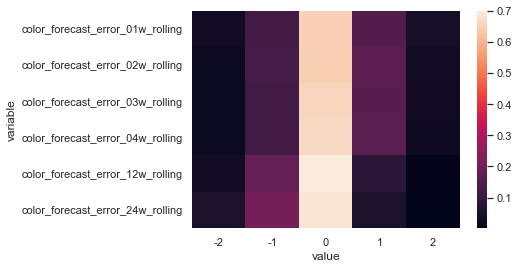

In [136]:
sns.heatmap(color_error_table)

Rolling Average Performance in 2018:
Raw Numbers:


value,-2,-1,0,1,2
variable,,,,,
color_forecast_error_01w_rolling,0.042336,0.135754,0.640123,0.136753,0.045034
color_forecast_error_02w_rolling,0.030729,0.161271,0.633366,0.142515,0.032120
color_forecast_error_03w_rolling,0.032153,0.166268,0.637883,0.135988,0.027708
color_forecast_error_04w_rolling,0.029841,0.174883,0.632825,0.136925,0.025526
color_forecast_error_12w_rolling,0.030164,0.173776,0.637638,0.133633,0.024789
color_forecast_error_24w_rolling,0.030164,0.173776,0.637638,0.133633,0.024789


Heatmap:


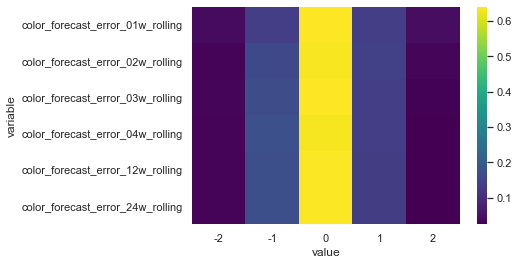

Pessimism Rates:


variable
color_forecast_error_01w_rolling    0.776876
color_forecast_error_02w_rolling    0.775881
color_forecast_error_03w_rolling    0.773871
color_forecast_error_04w_rolling    0.769750
color_forecast_error_12w_rolling    0.771271
color_forecast_error_24w_rolling    0.771271
dtype: float64


Rolling Average Performance in 2019:
Raw Numbers:


value,-2,-1,0,1,2
variable,,,,,
color_forecast_error_01w_rolling,0.048045,0.133845,0.639875,0.129887,0.048348
color_forecast_error_02w_rolling,0.035775,0.168385,0.628020,0.134672,0.033148
color_forecast_error_03w_rolling,0.036160,0.176233,0.632262,0.127364,0.027981
color_forecast_error_04w_rolling,0.030747,0.192709,0.623398,0.128236,0.024911
color_forecast_error_12w_rolling,0.028892,0.196139,0.630540,0.121779,0.022651
color_forecast_error_24w_rolling,0.029277,0.200719,0.625881,0.122450,0.021672


Heatmap:


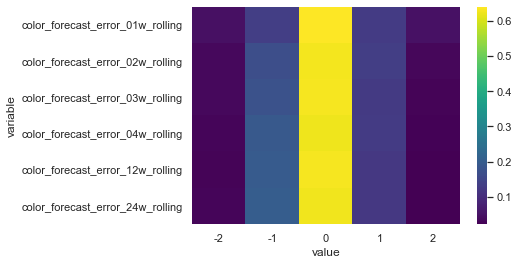

Pessimism Rates:


variable
color_forecast_error_01w_rolling    0.769762
color_forecast_error_02w_rolling    0.762692
color_forecast_error_03w_rolling    0.759626
color_forecast_error_04w_rolling    0.751634
color_forecast_error_12w_rolling    0.752319
color_forecast_error_24w_rolling    0.748332
dtype: float64


Rolling Average Performance in 2020:
Raw Numbers:


value,-2,-1,0,1,2
variable,,,,,
color_forecast_error_01w_rolling,0.038871,0.110473,0.698406,0.110184,0.042066
color_forecast_error_02w_rolling,0.032834,0.137507,0.687563,0.113639,0.028456
color_forecast_error_03w_rolling,0.036332,0.146916,0.688749,0.103195,0.024809
color_forecast_error_04w_rolling,0.033997,0.160819,0.673744,0.108417,0.023024
color_forecast_error_12w_rolling,0.046419,0.165823,0.626645,0.134079,0.027034
color_forecast_error_24w_rolling,0.033562,0.155213,0.581105,0.193988,0.036132


Heatmap:


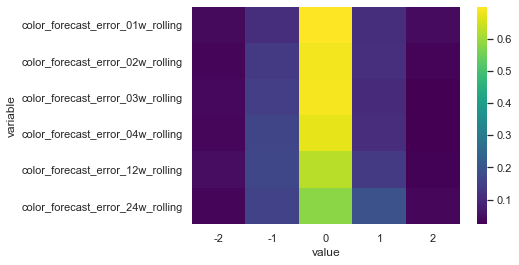

Pessimism Rates:


variable
color_forecast_error_01w_rolling    0.808590
color_forecast_error_02w_rolling    0.801202
color_forecast_error_03w_rolling    0.791944
color_forecast_error_04w_rolling    0.782161
color_forecast_error_12w_rolling    0.760724
color_forecast_error_24w_rolling    0.775093
dtype: float64


Rolling Average Performance in Pandemic:
Raw Numbers:


value,-2,-1,0,1,2
variable,,,,,
color_forecast_error_01w_rolling,0.031164,0.098925,0.732037,0.100943,0.036931
color_forecast_error_02w_rolling,0.028302,0.117961,0.723670,0.105970,0.024097
color_forecast_error_03w_rolling,0.034909,0.122474,0.725077,0.095680,0.021859
color_forecast_error_04w_rolling,0.035154,0.130831,0.708864,0.103680,0.021471
color_forecast_error_12w_rolling,0.055593,0.143032,0.626519,0.145500,0.029357
color_forecast_error_24w_rolling,0.036953,0.135657,0.555692,0.228675,0.043023


Heatmap:


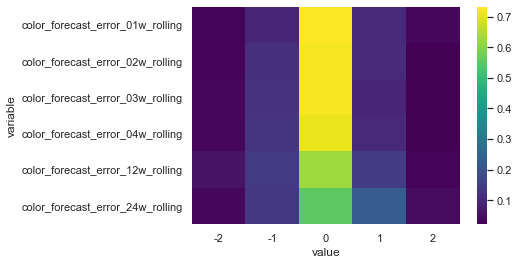

Pessimism Rates:


variable
color_forecast_error_01w_rolling    0.832980
color_forecast_error_02w_rolling    0.829640
color_forecast_error_03w_rolling    0.820758
color_forecast_error_04w_rolling    0.812544
color_forecast_error_12w_rolling    0.772019
color_forecast_error_24w_rolling    0.784367
dtype: float64


Rolling Average Performance in Pandemic_Q4:
Raw Numbers:


value,-2,-1,0,1,2
variable,,,,,
color_forecast_error_01w_rolling,0.033704,0.122554,0.651372,0.147767,0.044603
color_forecast_error_02w_rolling,0.020831,0.128636,0.648537,0.169855,0.032141
color_forecast_error_03w_rolling,0.022523,0.121652,0.661973,0.164700,0.029152
color_forecast_error_04w_rolling,0.019768,0.123545,0.665139,0.165997,0.025552
color_forecast_error_12w_rolling,0.031658,0.183026,0.700437,0.079224,0.005655
color_forecast_error_24w_rolling,0.052666,0.210905,0.684222,0.050918,0.001289


Heatmap:


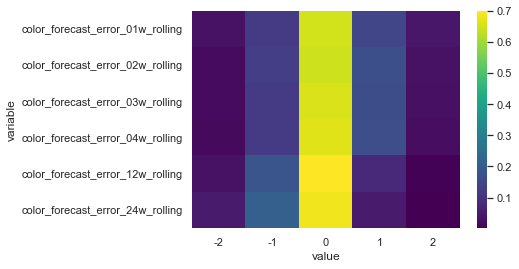

Pessimism Rates:


variable
color_forecast_error_01w_rolling    0.799140
color_forecast_error_02w_rolling    0.818392
color_forecast_error_03w_rolling    0.826673
color_forecast_error_04w_rolling    0.831136
color_forecast_error_12w_rolling    0.779662
color_forecast_error_24w_rolling    0.735140
dtype: float64

In [137]:
for name, color_error_table in color_error_tables.items():
    print(f'Rolling Average Performance in {name.title()}:')
    print('Raw Numbers:')
    display(color_error_table)
    print('Heatmap:')
    sns.heatmap(color_error_table, cmap='viridis')
    plt.show()
    print('Pessimism Rates:')
    display(color_error_table[[c for c in color_error_table.columns if 0 <= c <= 1]].sum(axis='columns'))
    print()

In [147]:
requested_dt = dt.datetime(2020, 1, 6, 8, 15)
pd.Timestamp(requested_dt)
# occupancy.semihour.head().iloc[0]

Timestamp('2020-01-06 08:15:00')

In [150]:
weeks_to_average = 1
training_data = occupancy.assign(
    available_rate=lambda df: 1 - df.occu_cnt_rate,
    dayofweek=lambda df: df.semihour.dt.dayofweek.astype('category'),
    semihour_tuples=lambda df: pd.Series(
        zip(df.semihour.dt.hour, df.semihour.dt.minute),
        dtype='category', index=df.index
    )
)
training_data = training_data.sort_values(
    ['zone_id', 'dayofweek', 'semihour_tuples']
)
training_data[f'available_rate_{weeks_to_average:0>2}w'] = (
    training_data.groupby(
        ['zone_id', 'dayofweek', 'semihour_tuples']
    ).available_rate.transform(
        lambda group: group.shift().rolling(weeks_to_average, 1).mean()
    ).clip(0, 1)
)
print(f'{training_data[f"available_rate_{weeks_to_average:0>2}w"]=}')
_supported_zones = training_data.zone_id.unique()
_rolling_averages = training_data.set_index(
    ['zone_id', 'semihour']
)[['semihour_tuples', f'available_rate_{weeks_to_average:0>2}w']]

training_data[f"available_rate_{weeks_to_average:0>2}w"]=2352       NaN
2548       1.0
2744       1.0
2940       1.0
3136       1.0
          ... 
7614588    1.0
7614784    1.0
7614980    1.0
7615176    1.0
7615344    1.0
Name: available_rate_01w, Length: 6219716, dtype: float64


In [108]:
foo = (occupancy[
         [f'color_forecast_error_{weeks:0>2}w_rolling' for weeks in windows_in_weeks]
     ].melt()
      .groupby(['variable', 'value'], sort=False)
      .size()
      .rename('count')
      .reset_index()
      .assign(
          proportion=lambda df: df['count'] / df.groupby('variable')['count'].transform(lambda s: s.sum())
      )
      .set_index(['variable', 'value'])
      .proportion
      .unstack())
# foo = foo.loc[[f'color_forecast_error_{weeks:0>2}w_rolling' for weeks in windows_in_weeks]]

In [115]:
foo[[c for c in foo.columns if 0 <= c <= 1]].sum(axis='columns')

variable
color_forecast_error_01w_rolling    0.784309
color_forecast_error_02w_rolling    0.777803
color_forecast_error_03w_rolling    0.772661
color_forecast_error_04w_rolling    0.764466
color_forecast_error_12w_rolling    0.757408
color_forecast_error_24w_rolling    0.760368
dtype: float64

<AxesSubplot:xlabel='value', ylabel='variable'>

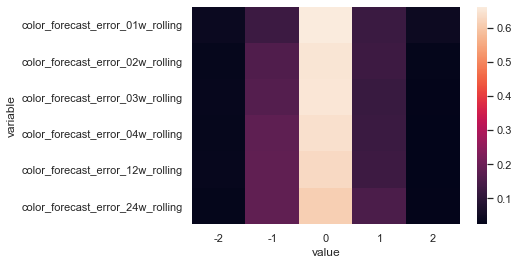

In [109]:
sns.heatmap(foo)

In [105]:
sns.heatmap(
    (occupancy[
         [f'color_forecast_error_{weeks}w_rolling' for weeks in windows_in_weeks]
     ].melt()
      .groupby(['variable', 'value'], sort=False)
      .size()
      .rename('count')
      .reset_index()
      .assign(
          proportion=lambda df: df['count'] / df.groupby('variable')['count'].transform(lambda s: s.sum())
      )
      .set_index(['variable', 'value'])
      .loc[[f'color_forecast_error_{weeks}w_rolling' for weeks in windows_in_weeks]]
      .proportion
      .unstack()
      .loc[[f'color_forecast_error_{weeks:0>2}w_rolling' for weeks in windows_in_weeks]])
)

KeyError: "Passing list-likes to .loc or [] with any missing labels is no longer supported. The following labels were missing: Index(['color_forecast_error_01w_rolling', 'color_forecast_error_02w_rolling',\n       'color_forecast_error_03w_rolling', 'color_forecast_error_04w_rolling'],\n      dtype='object', name='variable'). See https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike"

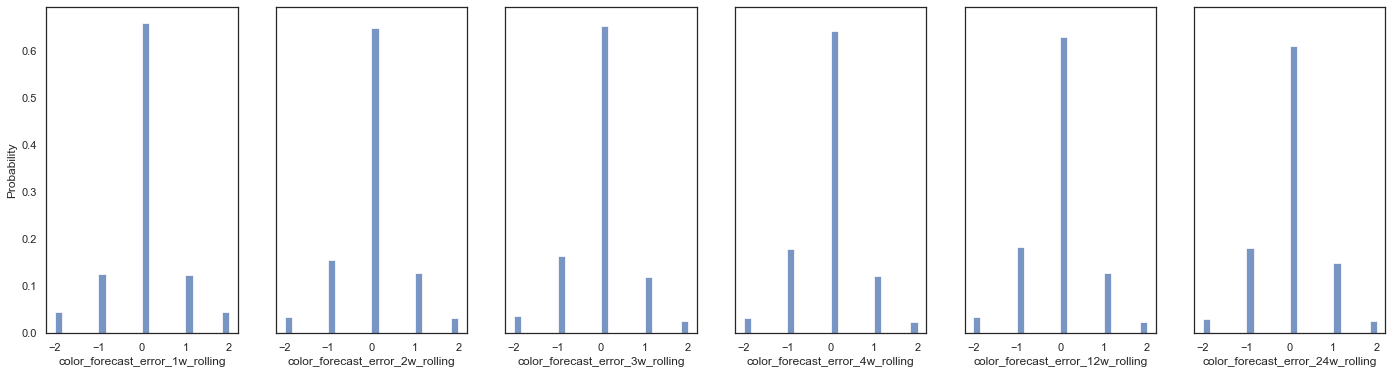

In [64]:
fig, axes = plt.subplots(1, len(windows_in_weeks), figsize=(24, 6), sharex=True, sharey=True)
for i, weeks in enumerate(windows_in_weeks):
    sns.histplot(
        occupancy[f'color_forecast_error_{weeks}w_rolling'],
        stat='probability',
        ax=axes[i]
    )

In [50]:
cfes = occupancy[[f'color_forecast_error_{weeks}w_rolling' for weeks in windows_in_weeks]]
cfes.columns = windows_in_weeks


 0    4248839
-1     810474
 1     797370
 2     293606
-2     284299
Name: 1, dtype: int64

In [ ]:
sept2019_pc_color_errors = {
    model_id: -(actual_colors - model_pc_colors)#.astype('category')
    for model_id, model_pc_colors in sept2019_pc_colors.items()
}

fig, axes = plt.subplots(1, 4, figsize=(24, 6), sharex=True, sharey=True)
for i, (key, vals) in enumerate(sept2019_pc_color_errors.items()):
    sns.histplot(vals, ax=axes[i])

## Define `y_test`

In [787]:
with open('pandemic_forecasts_by_start_date.pkl', 'rb') as f:
    pandemic_forecasts_by_start_date = pickle.load(f)


def maybe_tqdm(iterable, interactive=True, **tqdm_kwargs):
    if interactive:
        wrapped_iterable = tqdm(iterable, **tqdm_kwargs)
    else:
        wrapped_iterable = iterable
    return wrapped_iterable


def y_test(occupancy_df, daily_zone_forecasts, interactive=True):
    y = {}
    for day, zone_forecasts in maybe_tqdm(daily_zone_forecasts.items()):
        y[day] = {}
        for zone, zone_forecast in maybe_tqdm(zone_forecasts.items(), leave=False):
            occupancy_df_in_zone_at_time = pd.merge(
                occupancy_df[occupancy_df.zone_id == zone],
                zone_forecast[['ds']],
                left_on='semihour',
                right_on='ds',
                how='right'
            )
            y[day][zone] = occupancy_df_in_zone_at_time.set_index('semihour')[['available_rate']]
    return y

In [788]:
y_test_sept2019 = y_test(occupancy, forecasts_by_start_date)
y_test_pandemic = y_test(occupancy, pandemic_forecasts_by_start_date)

## Define Metrics

In [621]:
from functools import wraps, reduce, partial
from operator import itemgetter
from typing import Callable, Iterable

def recursive_operator(operator=None, *, valid_input_class=(pd.Series,)):
    if operator is None:
        return lambda operator: recursive_operator(operator, valid_input_class=valid_input_class)
    @wraps(operator)
    def recursively_operate(*args, **kwargs):
        if all(isinstance(dataset, valid_input_class) for dataset in args):
            return operator(*args, **kwargs)
        elif all(isinstance(dataset, list) for dataset in args):
            if len({len(dataset) for dataset in args}) != 1:
                raise ValueError('args are lists of different sizes.')
            return [recursively_operate(*dataset_tuple, **kwargs)
                    for dataset_tuple in zip(*args)]
        elif all(isinstance(dataset, dict) for dataset in args):
            if any(set(dataset.keys()) != set(args[0].keys()) for dataset in args):
                raise ValueError('All args must have the same keys.')
            return {group: recursively_operate(*map(itemgetter(group), args),
                                               **kwargs)
                    for group in args[0].keys()}
        else:
            types = list(map(type, args))
            raise NotImplementedError(f'Unhandled type found in args. (Types in args: {types})')
    return recursively_operate

## Define `y_train`

In [719]:
y_train_sept2019 = y_train(occupancy, TRAINING_START_DATES)
y_train_pandemic = y_train(occupancy, pandemic_training_start_dates)

## Forecast Error Calculations

In [741]:
forecasts_sept2019 = pd.DataFrame.from_dict(
    {
        (zone_id, forecast.ds.dayofweek, (forecast.ds.hour, forecast.ds.minute)): forecast
        for _, forecasts_all_zones in forecasts_by_start_date.items()
        for zone_id, forecast_single_zone in forecasts_all_zones.items()
        for _, forecast in forecast_single_zone.iterrows()
    },
    orient='index'
).rename_axis(index=('zone_id', 'day_of_week', 'semihour')).drop(columns='ds')

y_test_sept2019_df = pd.DataFrame.from_dict(
    {
        (zone_id, forecast.ds): forecast
        for _, forecasts_all_zones in forecasts_by_start_date.items()
        for zone_id, forecast_single_zone in forecasts_all_zones.items()
        for _, forecast in forecast_single_zone.iterrows()
    },
    orient='index'
).rename_axis(index=('zone_id', 'ds')).drop(columns='ds')

In [742]:
forecasts_sept2019

# .reset_index(level=-1).assign(
#     semihour=lambda df: df.ds
#                           .map(lambda s: (s.hour, 30 * (s.minute // 30)))
# )

# loc(forecasts_sept2019, columns_criterion='ds')
# forecasts_sept2019.reset_index(level=-1).ds.map(lambda s: (s.dayofweek, s.hour, 30 * (s.minute // 30)))

trend  yhat_lower  yhat_upper  trend_lower  \
zone_id day_of_week semihour                                                  
17012   0           (8, 0)    0.806951    0.716495    1.275695     0.806951   
                    (8, 30)   0.806955    0.444985    0.984699     0.806955   
                    (9, 0)    0.806960    0.226105    0.766902     0.806960   
                    (9, 30)   0.806965    0.045065    0.603785     0.806965   
                    (10, 0)   0.806970   -0.051290    0.508494     0.806970   
...                                ...         ...         ...          ...   
72060   4           (19, 30)  0.737865    0.309558    1.083106     0.737865   
                    (20, 0)   0.737831    0.292995    1.066098     0.737831   
                    (20, 30)  0.737796    0.308266    1.049405     0.737796   
                    (21, 0)   0.737762    0.330418    1.066643     0.737762   
                    (21, 30)  0.737727    0.316568    1.031554     0.737727   

                              trend_upper  additive_terms  \
zone_id day_of_week semihour                                
17012   0           (8, 0)       0.806951        0.183731   
                    (8, 30)      0.806955       -0.092554   
                    (9, 0)       0.806960       -0.321237   
                    (9, 30)      0.806965       -0.486922   
                    (10, 0)      0.806970       -0.586515   
...                                   ...             ...   
72060   4           (19, 30)     0.737865       -0.038743   
                    (20, 0)      0.737831       -0.050462   
                    (20, 30)     0.737796       -0.061026   
                    (21, 0)      0.737762       -0.069514   
                    (21, 30)     0.737727       -0.075308   

                              additive_terms_lower  additive_terms_upper  \
zone_id day_of_week semihour                                               
17012   0           (8, 0)                0.183731              0.183731   
                    (8, 30)              -0.092554             -0.092554   
                    (9, 0)               -0.321237             -0.321237   
                    (9, 30)              -0.486922             -0.486922   
                    (10, 0)              -0.586515             -0.586515   
...                                            ...                   ...   
72060   4           (19, 30)             -0.038743             -0.038743   
                    (20, 0)              -0.050462             -0.050462   
                    (20, 30)             -0.061026             -0.061026   
                    (21, 0)              -0.069514             -0.069514   
                    (21, 30)             -0.075308             -0.075308   

                                 daily  daily_lower  daily_upper    weekly  \
zone_id day_of_week semihour                                                 
17012   0           (8, 0)    0.275780     0.275780     0.275780 -0.092049   
                    (8, 30)  -0.008227    -0.008227    -0.008227 -0.084327   
                    (9, 0)   -0.244645    -0.244645    -0.244645 -0.076592   
                    (9, 30)  -0.418056    -0.418056    -0.418056 -0.068866   
                    (10, 0)  -0.525345    -0.525345    -0.525345 -0.061170   
...                                ...          ...          ...       ...   
72060   4           (19, 30) -0.035925    -0.035925    -0.035925 -0.002818   
                    (20, 0)  -0.049088    -0.049088    -0.049088 -0.001374   
                    (20, 30) -0.061125    -0.061125    -0.061125  0.000099   
                    (21, 0)  -0.071109    -0.071109    -0.071109  0.001595   
                    (21, 30) -0.078421    -0.078421    -0.078421  0.003112   

                              weekly_lower  weekly_upper  \
zone_id day_of_week semihour                               
17012   0           (8, 0)       -0.092049     -0.092049   
                    (8, 30)

In [701]:
mae_sept2019 = pd.DataFrame(
    mae(
        loc(y_test_sept2019, columns_criterion='available_rate'),
        pipe(
            forecasts_by_start_date,
            to=lambda df: df[['ds', 'yhat']].set_index('ds').yhat.clip(0, 1)
        )
    )
)
mae_sept2019.columns = mae_sept2019.columns.map(
    lambda x: (pd.Timestamp(x) + pd.Timedelta(days=371)).date())

mae_pandemic = pd.DataFrame(
    mae(
        loc(y_test_pandemic, columns_criterion='available_rate'),
        pipe(
            pandemic_forecasts_by_start_date,
            to=lambda df: df[['ds', 'yhat']].set_index('ds').yhat.clip(0, 1)
        )
    )
)
mae_pandemic.columns = mae_pandemic.columns.map(
    lambda x: (pd.Timestamp(x) + pd.Timedelta(days=371)).date())

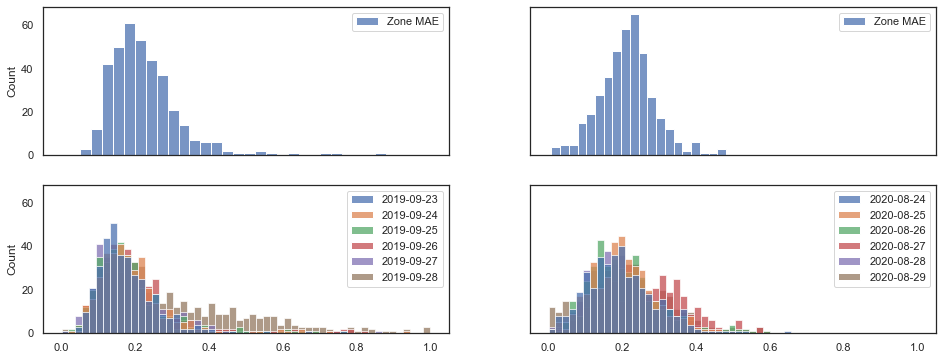

In [681]:
fig, axes = plt.subplots(2, 2, figsize=(16, 6), sharex=True, sharey=True)
sns.histplot(pd.DataFrame(mae_sept2019.stack().groupby(level=0).mean().rename('Zone MAE')), ax=axes[0][0]);
sns.histplot(pd.DataFrame(mae_pandemic.stack().groupby(level=0).mean().rename('Zone MAE')), ax=axes[0][1]);
sns.histplot(pd.DataFrame(mae_sept2019), ax=axes[1][0]);
sns.histplot(pd.DataFrame(mae_pandemic), ax=axes[1][1]);

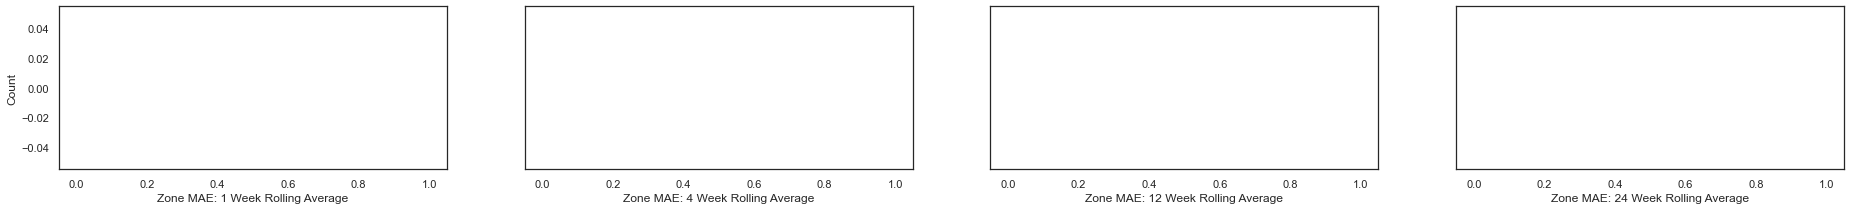

In [40]:
fig, axes = plt.subplots(1, 4, figsize=(32, 3), sharex=True, sharey=True, squeeze=False)
for plot_idx, weeks in enumerate([1, 4, 12, 24]):
    occupancy = occupancy.assign(
        **{
            f'ae_{weeks}w_rolling': lambda df: df[f'forecast_error_{weeks}w_rolling'].abs()
        }
    ).assign(
        **{
            f'mae_{weeks}w_rolling': lambda df: df.groupby(['zone_id'])[f'ae_{weeks}w_rolling'].mean()
        }
    )
    sns.histplot(
        occupancy[f'mae_{weeks}w_rolling'].rename(f'Zone MAE: {weeks} Week Rolling Average'),
        ax=axes[0][plot_idx]
    );
#     sns.histplot(pd.DataFrame(mae_pandemic.stack().groupby(level=0).mean().rename('Zone MAE')), ax=axes[0][1]);

In [665]:
display(mae_sept2019.describe(percentiles=np.linspace(0, 1, 11)))
display(mae_pandemic.describe(percentiles=np.linspace(0, 1, 11)))

,2019-09-23,2019-09-24,2019-09-25,2019-09-26,2019-09-27,2019-09-28
count,359.000000,359.000000,358.000000,358.000000,358.000000,351.000000
mean,0.178063,0.193245,0.189436,0.200689,0.188607,0.365322
std,0.085368,0.106297,0.108805,0.125865,0.105845,0.193508
min,0.000000,0.017857,0.026786,0.005233,0.002464,0.011604
0%,0.000000,0.017857,0.026786,0.005233,0.002464,0.011604
10%,0.095167,0.095749,0.092454,0.092862,0.089803,0.159060
20%,0.115928,0.123022,0.113134,0.117979,0.108903,0.203694
30%,0.131516,0.141589,0.132657,0.136974,0.126523,0.231674
40%,0.143242,0.153846,0.150781,0.156497,0.144877,0.283075
50%,0.157013,0.172594,0.166528,0.175293,0.166199,0.327119


,2020-08-24,2020-08-25,2020-08-26,2020-08-27,2020-08-28,2020-08-29
count,403.000000,403.000000,402.000000,402.000000,404.000000,405.000000
mean,0.197815,0.205783,0.206410,0.257344,0.197981,0.208419
std,0.095263,0.086473,0.098347,0.111397,0.088647,0.114805
min,0.000000,0.002054,0.001434,0.001010,0.001887,0.000000
0%,0.000000,0.002054,0.001434,0.001010,0.001887,0.000000
10%,0.084515,0.101965,0.101966,0.120919,0.096851,0.063302
20%,0.115670,0.129341,0.129425,0.160489,0.127082,0.113823
30%,0.145438,0.157906,0.145268,0.189953,0.146414,0.142832
40%,0.166275,0.181971,0.169396,0.222864,0.167548,0.172717
50%,0.189178,0.197954,0.191093,0.246508,0.188541,0.194679


## ParkColumbus Performance

In [747]:
mae_sept2019_nested = mae(
    loc(y_test_sept2019, columns_criterion='available_rate'),
    pipe(
        forecasts_by_start_date,
        to=lambda df: df[['ds', 'yhat']].set_index('ds').yhat.clip(0, 1)
    )
)

In [779]:
def flatten_predictions(predictions_by_day_and_zone, ignore_index=False):
    return pd.concat([
        predictions.assign(zone_id=zone_id)
        for predictions_by_zone in predictions_by_day_and_zone.values()
        for zone_id, predictions in predictions_by_zone.items()
    ], ignore_index=ignore_index)


forecasts_sept2019 = flatten_predictions(forecasts_by_start_date, ignore_index=True)
forecasts_pandemic = flatten_predictions(pandemic_forecasts_by_start_date, ignore_index=True)

In [791]:
y_test_sept2019_flat = flatten_predictions(y_test_sept2019)
y_test_pandemic_flat = flatten_predictions(y_test_pandemic)

In [832]:
y_test_sept2019_flat_cn = y_test_sept2019_flat.reset_index().rename(columns={'semihour': 'ds'}).dropna(subset=['ds']).set_index(['ds', 'zone_id']).available_rate.sort_index()
forecasts_sept2019_cn = forecasts_sept2019.set_index(['ds', 'zone_id']).yhat.clip(0, 1).sort_index()

y_test_pandemic_flat_cn = y_test_pandemic_flat.reset_index().rename(columns={'semihour': 'ds'}).dropna(subset=['ds']).set_index(['ds', 'zone_id']).available_rate.sort_index()
forecasts_pandemic_cn = forecasts_pandemic.set_index(['ds', 'zone_id']).yhat.clip(0, 1).sort_index()

In [833]:
common_indices_sept2019 = set(y_test_sept2019_flat_cn.index) & set(forecasts_sept2019_cn.index)
forecast_errors_sept2019 = (y_test_sept2019_flat_cn - forecasts_sept2019_cn)[common_indices_sept2019]

common_indices_pandemic = set(y_test_pandemic_flat_cn.index) & set(forecasts_pandemic_cn.index)
forecast_errors_pandemic = (y_test_pandemic_flat_cn - forecasts_pandemic_cn)[common_indices_pandemic]

<AxesSubplot:ylabel='Count'>

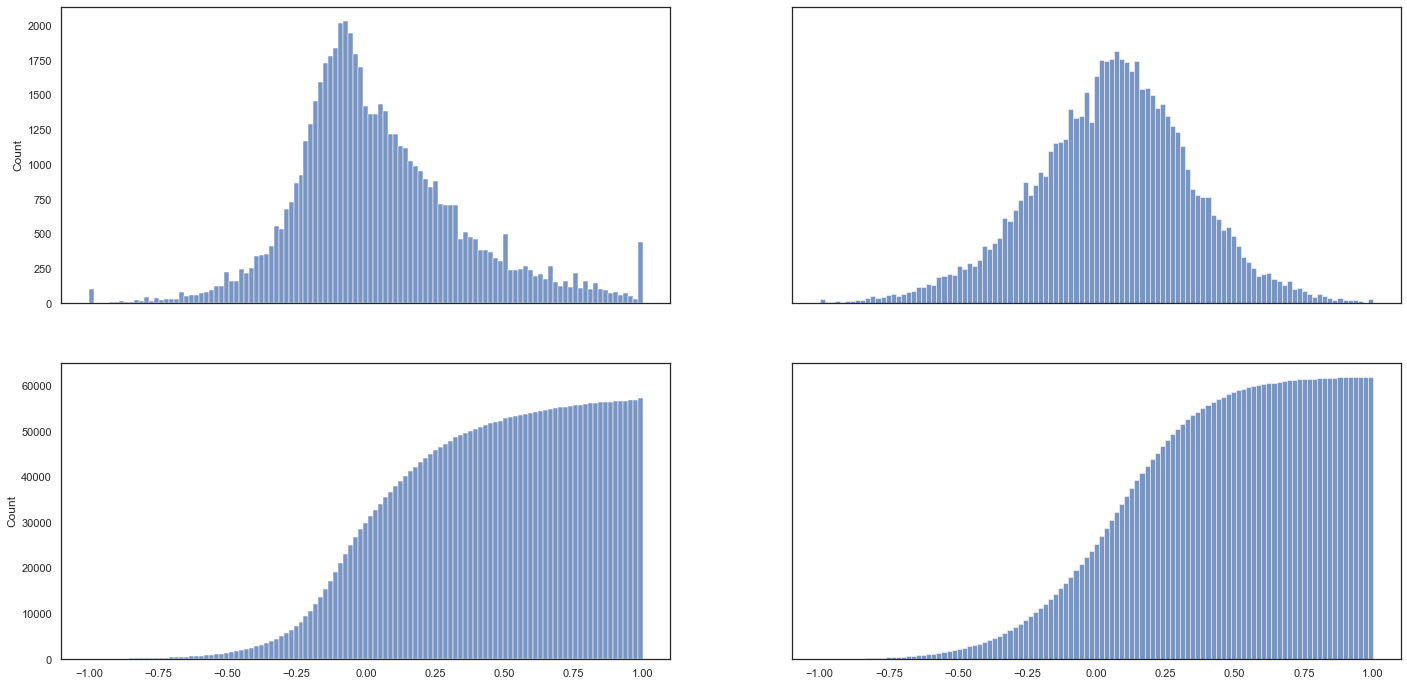

In [838]:
fig, axes = plt.subplots(2, 2, figsize=(24, 12), sharex=True, sharey='row')

sns.histplot(forecast_errors_sept2019.loc[lambda s: s != 0], ax=axes[0][0])
sns.histplot(forecast_errors_sept2019.loc[lambda s: s != 0], cumulative=True, ax=axes[1][0])
sns.histplot(forecast_errors_pandemic.loc[lambda s: s != 0], ax=axes[0][1])
sns.histplot(forecast_errors_pandemic.loc[lambda s: s != 0], cumulative=True, ax=axes[1][1])

## ParkColumbus Zone Prediction Efficacy

In [844]:
availability_boundaries = [0, .20, .50, 1]
availability_labels = ['Red', 'Yellow', 'Green']

color_hat_sept2019 = pd.cut(
    forecasts_sept2019_cn[common_indices_sept2019],
    availability_boundaries,
    include_lowest=True,
    labels=availability_labels
)
color_sept2019 = pd.cut(
    y_test_sept2019_flat_cn[common_indices_sept2019],
    availability_boundaries,
    include_lowest=True,
    labels=availability_labels
)

color_hat_pandemic = pd.cut(
    forecasts_pandemic_cn[common_indices_pandemic],
    availability_boundaries,
    include_lowest=True,
    labels=availability_labels
)
color_pandemic = pd.cut(
    y_test_pandemic_flat_cn[common_indices_pandemic],
    availability_boundaries,
    include_lowest=True,
    labels=availability_labels
)

In [845]:
color_hat_sept2019_correct = color_hat_sept2019 == color_sept2019
color_hat_sept2019_pessimistic = color_hat_sept2019 < color_sept2019
color_hat_sept2019_optimistic = color_hat_sept2019 > color_sept2019

color_hat_pandemic_correct = color_hat_pandemic == color_pandemic
color_hat_pandemic_pessimistic = color_hat_pandemic < color_pandemic
color_hat_pandemic_optimistic = color_hat_pandemic > color_pandemic

<BarContainer object of 3 artists>

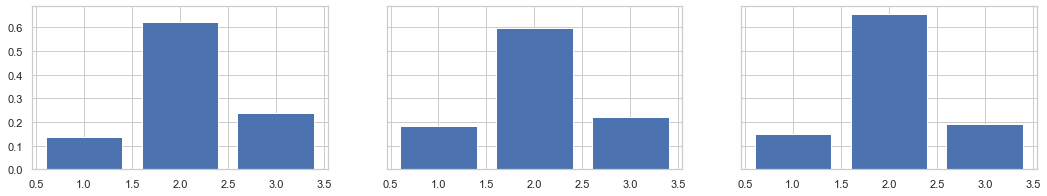

In [866]:
import matplotlib as mpl

with open('agility.pkl', 'rb') as f:
    production_model_outlook_ratios = pickle.load(f)

sns.set_theme(style='whitegrid')
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(18, 3))

ax1.bar(
    [1, 2, 3],
    production_model_outlook_ratios
)

ax2.bar(
    [1, 2, 3],
    [
        color_hat_sept2019_pessimistic.sum() / color_hat_sept2019_pessimistic.shape[0],
        color_hat_sept2019_correct.sum() / color_hat_sept2019_pessimistic.shape[0],
        color_hat_sept2019_optimistic.sum() / color_hat_sept2019_pessimistic.shape[0]
    ]
)
# ax1.scatter(np.linspace(0.5, 3.5), 50 * [10000], marker='_')
ax3.bar(
    [1, 2, 3],
    [
        color_hat_pandemic_pessimistic.sum() / color_hat_pandemic_pessimistic.shape[0],
        color_hat_pandemic_correct.sum() / color_hat_pandemic_pessimistic.shape[0],
        color_hat_pandemic_optimistic.sum() / color_hat_pandemic_pessimistic.shape[0]
    ]
)
# ax2.scatter(np.linspace(0.5, 3.5), 50 * [10000], marker='_')